## 预测最后一个值

为演示训练RNN，可以根据可用的历史数据预测时间序列中的最后一个值，我们定义一个合成数据集。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# 加载数据集
df = pd.read_csv('Summary of Weather.csv')

# 查看数据集信息
print(df.head())
print(df.info())

# 假设我们要预测温度，选择相关列并处理时间信息
# 这里假设数据集有Date和Temperature列
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')  # 确保按时间排序
temperature_column = 'MaxTemp'  # 假设使用这个列名
data = df[temperature_column].values.reshape(-1, 1)

# 数据归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data).astype(np.float32)
# 创建时间序列数据
def create_sequences(data, n_steps, n_forecast):
    X, y = [], []
    for i in range(len(data) - n_steps - n_forecast + 1):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps:i+n_steps+n_forecast, 0])
    return np.array(X), np.array(y)

     STA      Date Precip  WindGustSpd    MaxTemp    MinTemp   MeanTemp  \
0  10001  1942-7-1  1.016          NaN  25.555556  22.222222  23.888889   
1  10001  1942-7-2      0          NaN  28.888889  21.666667  25.555556   
2  10001  1942-7-3   2.54          NaN  26.111111  22.222222  24.444444   
3  10001  1942-7-4   2.54          NaN  26.666667  22.222222  24.444444   
4  10001  1942-7-5      0          NaN  26.666667  21.666667  24.444444   

  Snowfall PoorWeather  YR  ...  FB  FTI ITH  PGT  TSHDSBRSGF  SD3  RHX  RHN  \
0      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
1      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
2      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
3      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
4      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   

  RVG  WTE  
0 NaN  NaN  
1 NaN  NaN  
2 NaN  NaN  
3 NaN  NaN  
4 N

C:\Users\yuxiangw\AppData\Local\Temp\ipykernel_56728\2255080374.py:9: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Summary of Weather.csv')


In [3]:
# 设置时间步长和预测长度
n_steps = 50  # 使用50个时间步来预测
n_forecast = 1  # 预测未来10个时间点

X, y = create_sequences(data_scaled, n_steps, n_forecast)

# 分割训练集、验证集和测试集
train_size = int(0.7 * len(X))
valid_size = int(0.2 * len(X))
test_size = len(X) - train_size - valid_size

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size+valid_size], y[train_size:train_size+valid_size]
X_test, y_test = X[train_size+valid_size:], y[train_size+valid_size:]

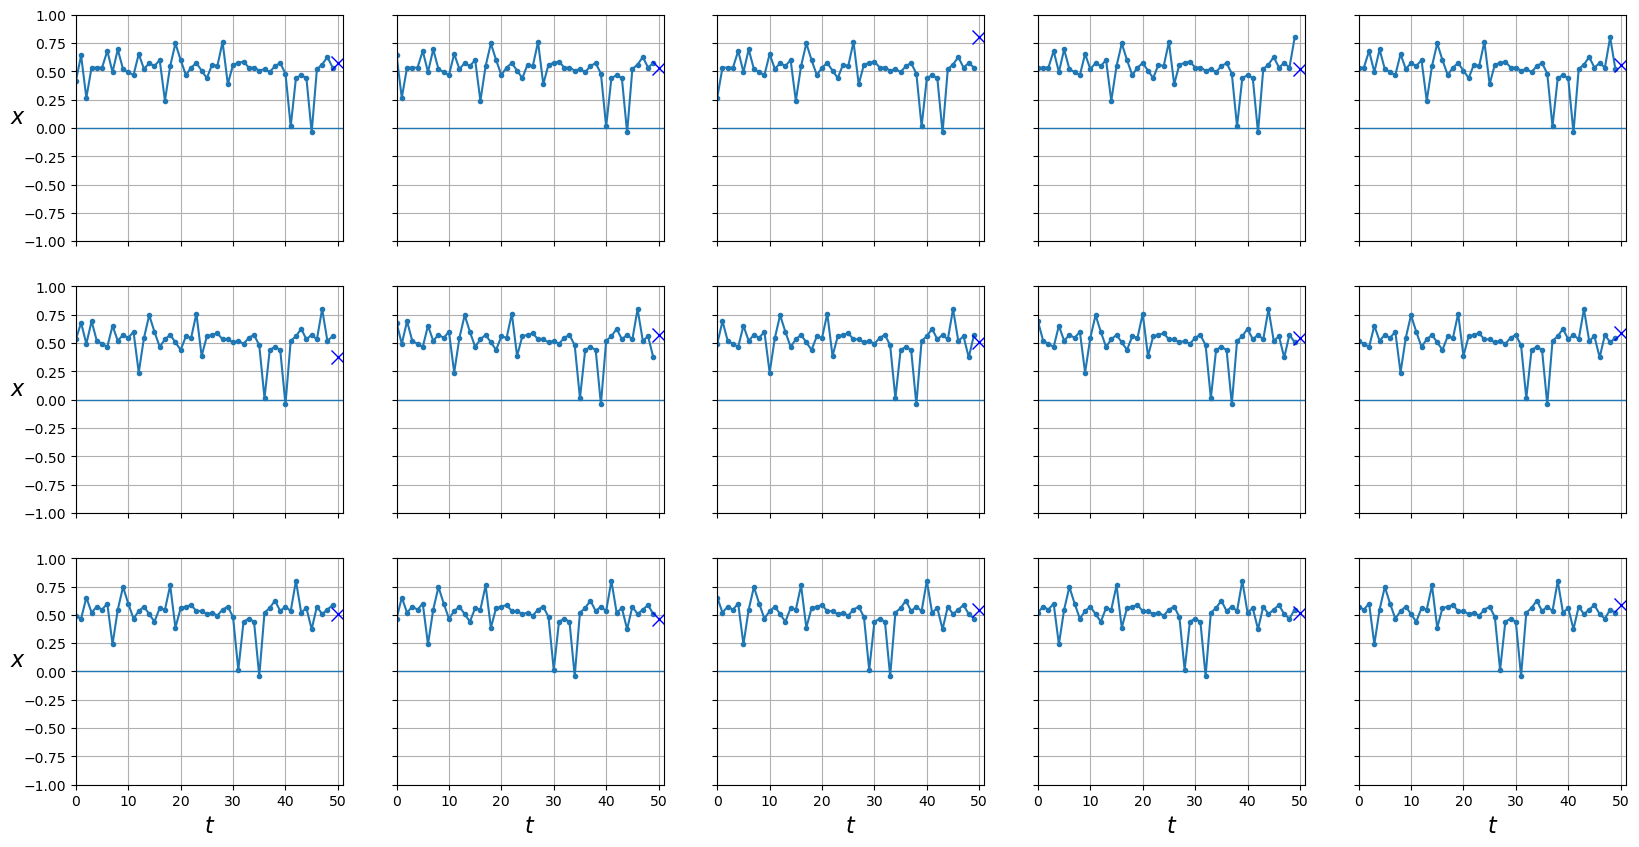

In [4]:
import matplotlib.pyplot as plt 

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
    r, c = 3, 5
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = col + row*c
            plt.plot(series[ix, :], ".-")
            if y is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
            if y_pred is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            plt.grid(True)
            plt.hlines(0, 0, 100, linewidth=1)
            plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
            if x_label and row == r - 1:
              plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
              plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.show()

plot_series(X_test, y_test)

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None, train=True):
        self.X = X
        self.y = y
        self.train = train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        if self.train:
            return torch.tensor(self.X[ix], dtype=torch.float32), torch.tensor(self.y[ix], dtype=torch.float32)
        return torch.tensor(self.X[ix], dtype=torch.float32)
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

我们训练一个RNN模型，它接受一个单一的输入值，连接到隐藏层中的20个神经元，最后一个时间步获得的20个结果值与一个神经元连接，产生预测的最终结果。

In [6]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [13]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    writer = SummaryWriter('runs/weather_forecast_experiment')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        batch_idx = 0
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            writer.add_scalar('Loss/train_batch', loss.item(), epoch * len(dataloader['train']) + batch_idx)
            batch_idx += 1
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [14]:
fit(rnn, dataloader)

loss 0.04444 val_loss 0.03484: 100%|██████████| 10/10 [00:37<00:00,  3.73s/it]


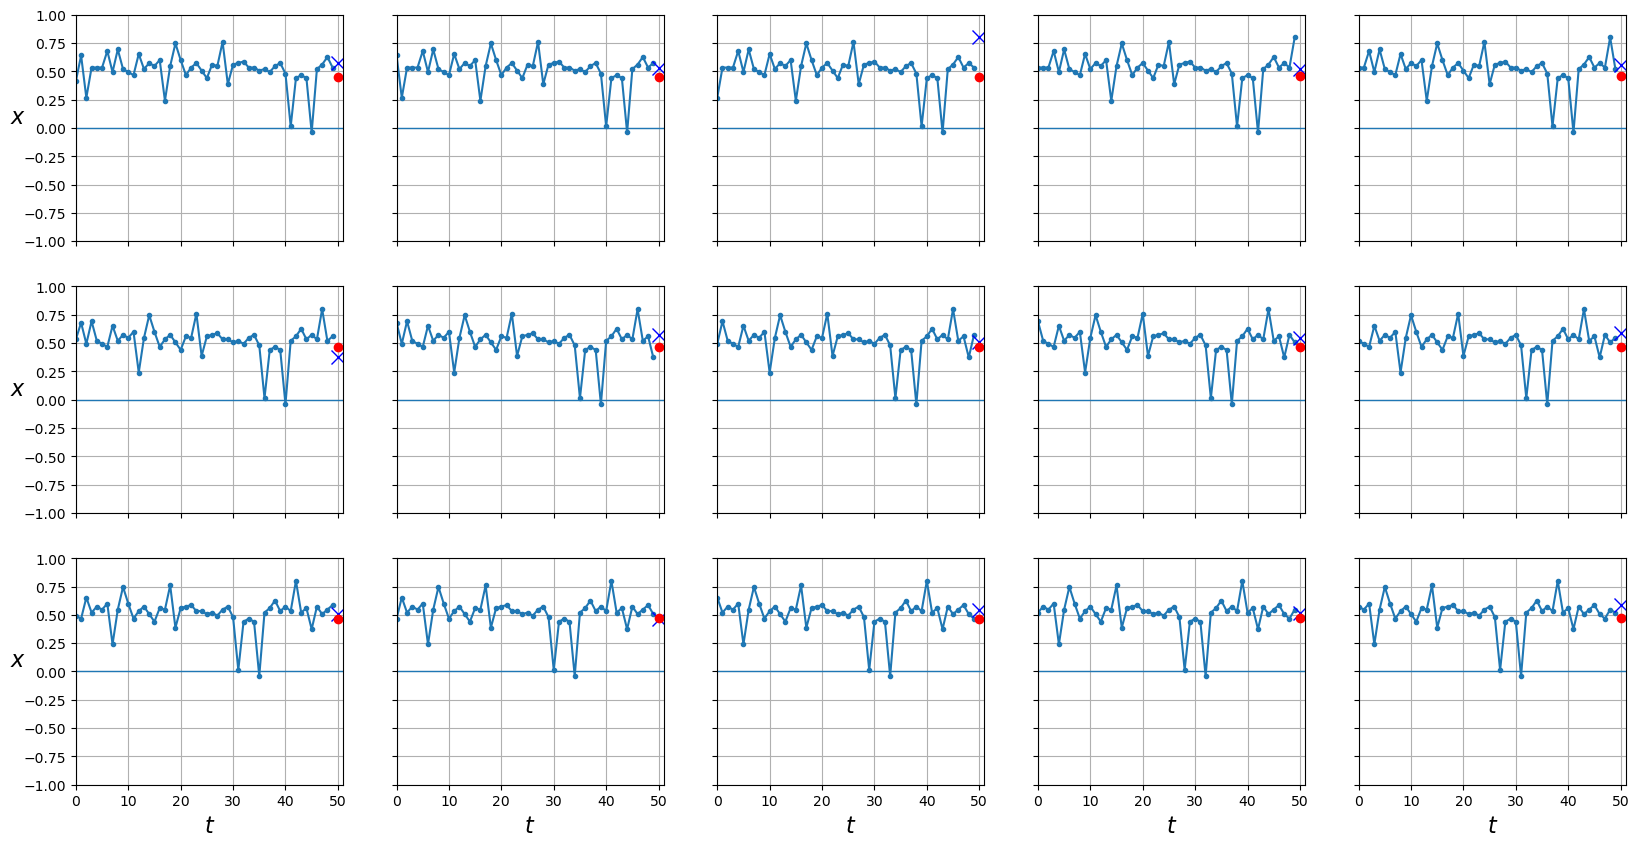

np.float32(0.037787907)

In [15]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

我们可以通过在所谓的RNN模型中添加更多隐藏层来改进模型。这将增加模型的能力，也可能会提高模型的性能。

In [16]:
# 使用 num_layers参数来控制循环神经网络（RNN）中的隐藏层数量
class DeepRNN(torch.nn.Module):
  def __init__(self, n_in=50, n_out=1):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [17]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.04450 val_loss 0.03331: 100%|██████████| 10/10 [00:39<00:00,  3.99s/it]


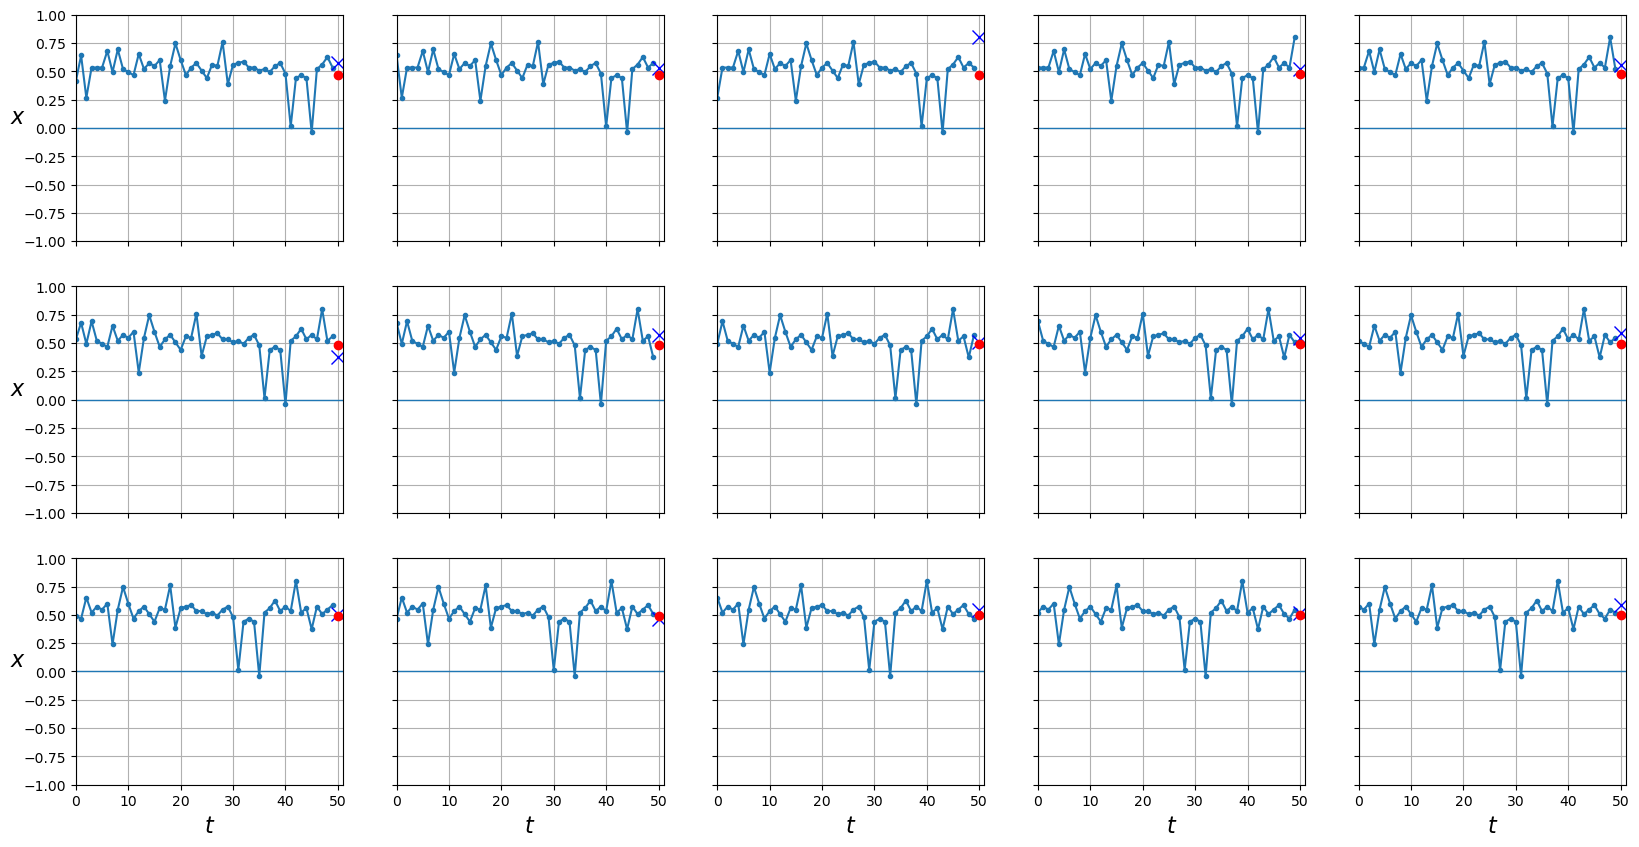

np.float32(0.038620394)

In [ ]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

## 预测多个值

对时间序列中的最后一个值的预测，帮助我们了解了RNN的工作原理。但是这种应用情况并不是很有用。能够预测一整个星期、一个月甚至一年的值，可以为相关应用带来更多价值。

让我们看看如何根据可用的历史数据预测时间序列中的最后10个值。

In [18]:
n_steps = 50  # 使用50个时间步来预测
n_forecast = 5  # 预测未来10个时间点

X, y = create_sequences(data_scaled, n_steps, n_forecast)

# 分割训练集、验证集和测试集
train_size = int(0.7 * len(X))
valid_size = int(0.2 * len(X))
test_size = len(X) - train_size - valid_size

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size+valid_size], y[train_size:train_size+valid_size]
X_test, y_test = X[train_size+valid_size:], y[train_size+valid_size:]

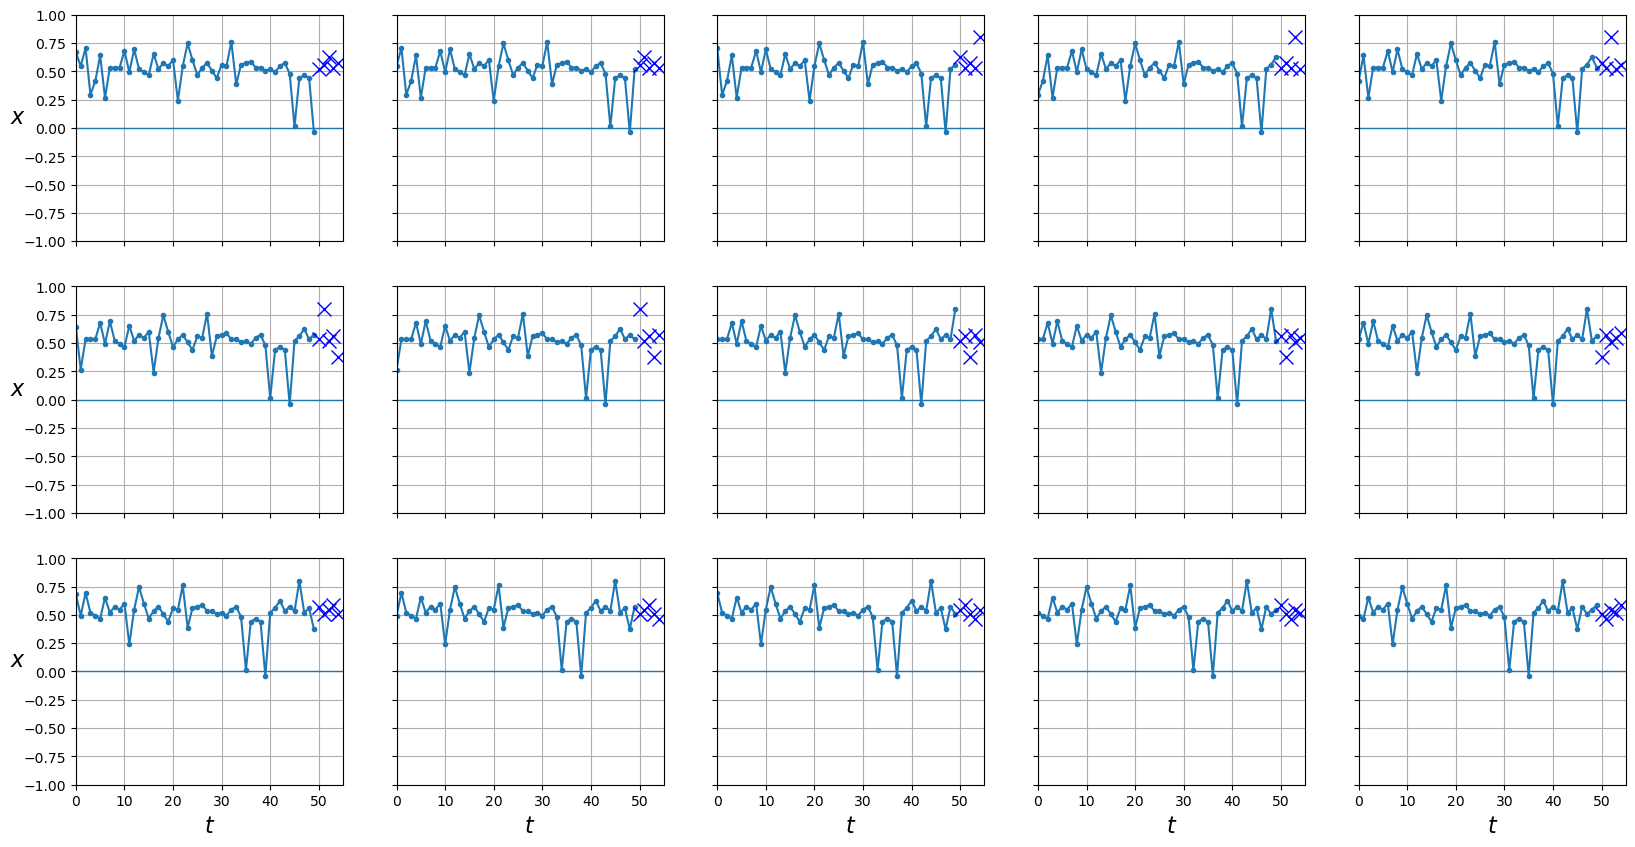

In [19]:
plot_series(X_test, y_test)

可以尝试使用RNN模型来完成这项任务，既然它能够预测最后一个值。那么，每当我们预测出一个值时，将其添加为输入的一部分，并预测下一个值，这样直到我们想要停止为止。

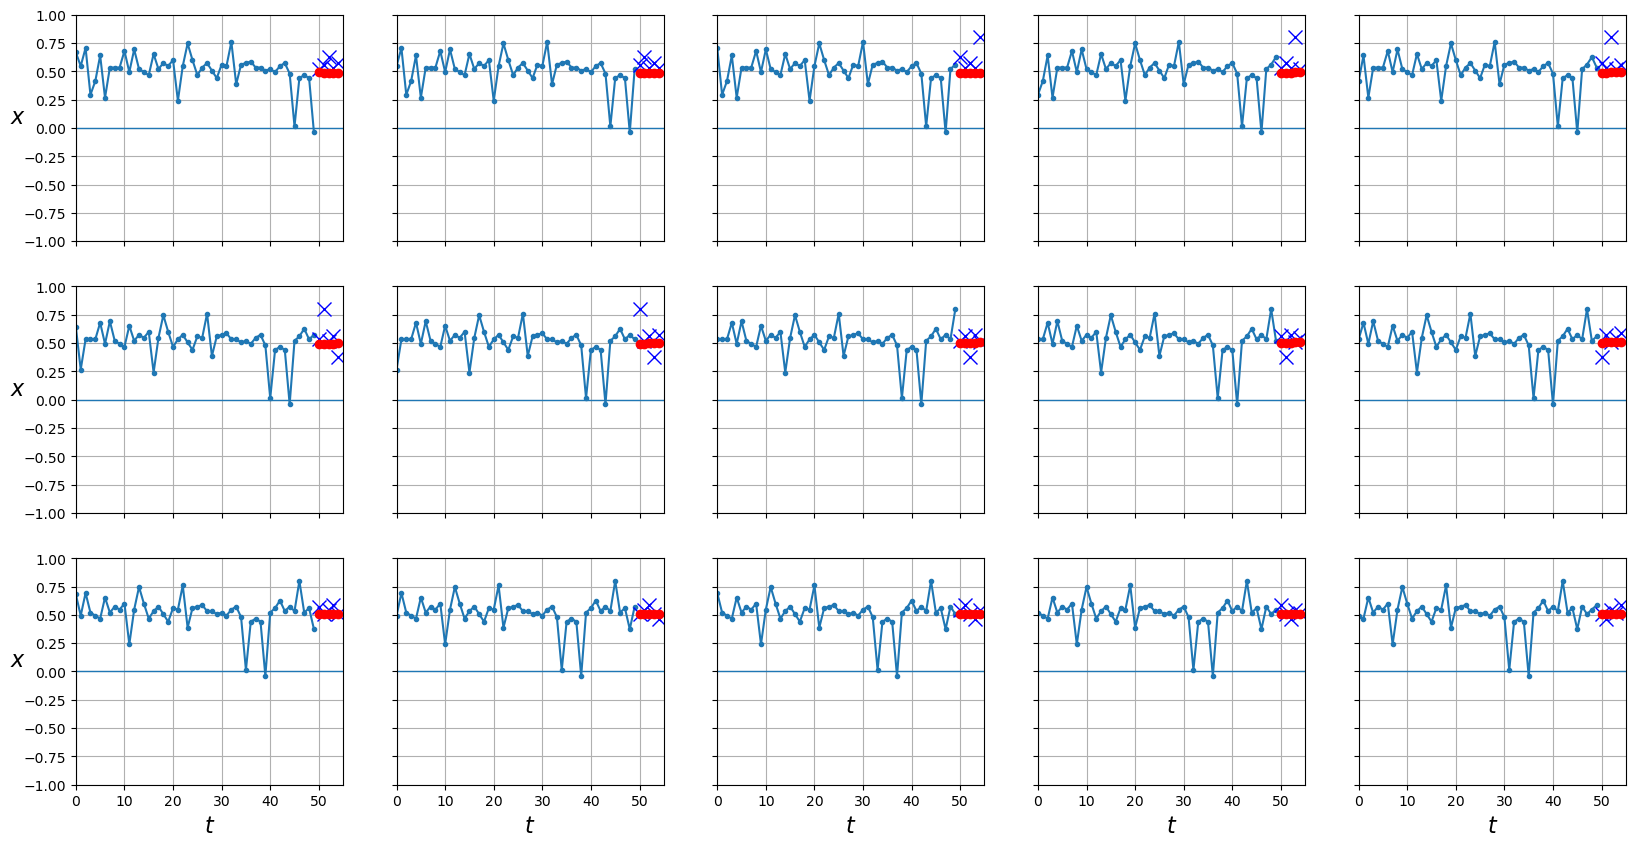

np.float32(0.037576627)

In [21]:
X = X_test
for step_ahead in range(5):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)
    y_pred_one = predict(rnn, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, y_test, y_pred)
mean_squared_error(y_test, y_pred)

这种方法很有用，实际上也被用于很多应用中。

但是，模型中的任何错误也会在连续的预测中被传播。这可以发现，我们在预测的最初时间阶段非常准确，但随着我们对未来值更多的预测，预测结果会逐渐变差。

从事实中可以看出：我们可以通过让模型在每个时刻预测接下来的10个时间点而不是仅仅1个来改善我们的结果。

In [22]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=5):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [23]:
rnn = DeepRNN()
fit(rnn, dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]d:\anaconda\envs\py312\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\anaconda\envs\py312\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([29, 1])) that is different to the input size (torch.Size([29, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\anaconda\envs\py312\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([54, 1])) that is different to the input size (torch.Size([54, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure t

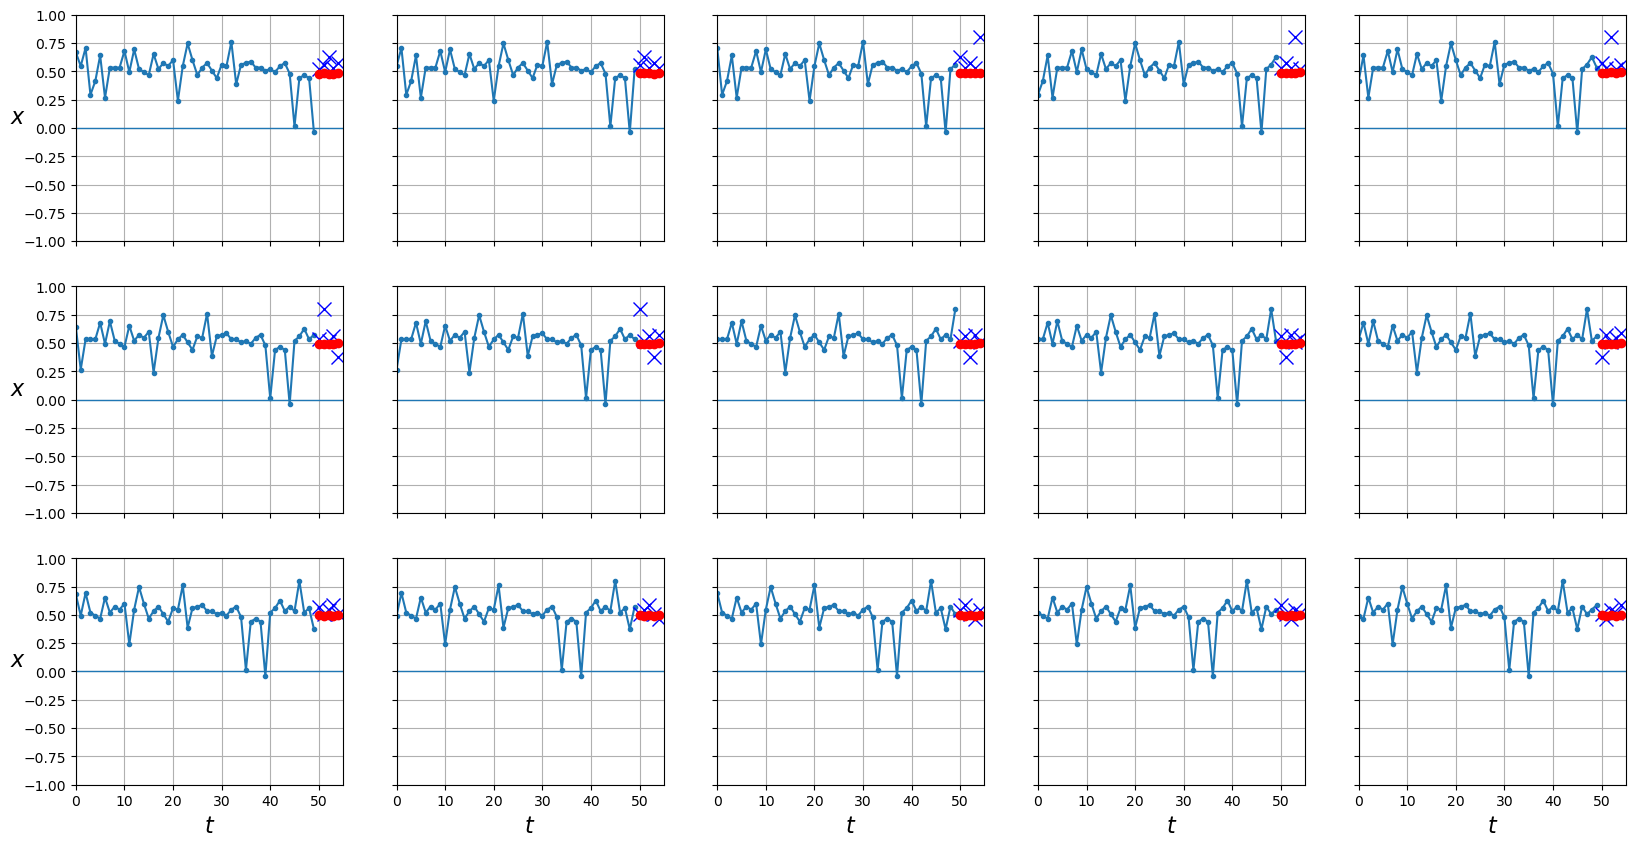

np.float32(0.037847918)

In [24]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())